# US Power Outage Durations in the Day vs. Night

Tommy Shen

## Summary of Findings

### Introduction
The power outage dataset from Purdue contains data pertaining to major power outages in the US from 2000-2015 and aggregates it with geographical, climate, economical, and time of occurrence information.

### Cleaning and EDA
The first step in the cleaning process was to reformat the excel table into a tidy format. Quantitative and time-related columns were typecast into numerical or Timestamp/datetime objects or their corresponding null types. Many of the original 55 variables were dropped. Since none of these steps involved imputing missing data or altering raw values, the data still accurately reflects the original data generating process.

### Assessment of Missingness
The missingness of the number of customers affected column is examined in this section. First the dependency of missingness was tested against the region's overseeing company using a permutation test of total variance distances. The result was statistically significant against an $\alpha$ = 0.05 significance level, suggesting that customer impact data is more likely to be missing for certain companies than others.

Next, the missingness of the number of customers affected column was tested against the climate category of the outage. With another permutation test of total variance distances on an $\alpha$ = 0.05 significance level, a non-statistically significant result was yielded. This suggests that the missingness of the number of customers does not depend on the climate type.

### Hypothesis Test
The focus of this section was whether or not the durations of power outages that occured after normal working hours were longer than those that occured during the typical workday. Specifically, the hypotheses were:
* $H_0$ = Power outage durations are similarly distributed regardless of when they occur
* $H_1$ = Power outages that start after-hours last longer

After running a permutation test of the difference in the mean durations of the two time categories, we obtained a statistically significant result against an $\alpha$ = 0.05 significance level, which suggests that major power outages in the US do last longer when they begin at night. One limitation of this analysis however, is that normal working hours are assumed to be 8AM to 5PM in the region's local time, which may not be accurate for all the service companies.

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import re
import datetime

### Cleaning and EDA

After loading the excel data of power outages into jupyter notebook, a few things are immediately noticeable:
* Column names are found on line 4 followed by a units label
* The first column is empty
* An observation id is provided under 'OBS'

In [2]:
#Load and preview dataset
outages = pd.read_excel('outage.xlsx')
outages.loc[0:6][outages.columns[0:9]]

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL
5,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,numeric
6,NaN,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3


In [3]:
#Set proper column names, remove empty header cells, drop empty 'variables' column
outages.columns = outages.loc[4].rename(None)
outages = outages[6:]
outages = outages.drop(['variables'], axis=1)
#Set index to OBS
outages = outages.set_index('OBS')
outages.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In this tidy rectangular format, we see that there are 55 variables on this dataset, many of which will not be used in the analysis. Columns related to the following are dropped:
* electrical consumption/cost
* regional economic characteristics
* geographical variables
* hurricane nomenclature
* population density

In [4]:
outages = outages.drop(['HURRICANE.NAMES', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS', 'CLIMATE.REGION',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT_WATER_INLAND', 'DEMAND.LOSS.MW'], axis=1)

After taking a closer look at the remaining columns, we see there is repeated data in some of the columns. For example, the 'YEAR' and 'MONTH' columns are already encoded in 'OUTAGE.START.DATE'. Such extraneous columns are dropped. 

In [5]:
outages = outages.drop(['YEAR', 'MONTH', 'U.S._STATE'], axis=1)
outages = outages.rename(columns={'POSTAL.CODE': 'STATE'})

Remaining columns in this dataset are type-casted as needed and start and restoration date columns are combined with their corresponding clock times. Lengthy column names are shortened via renaming.

In [6]:
#Examine column datatypes
outages.dtypes

STATE                      object
NERC.REGION                object
ANOMALY.LEVEL              object
CLIMATE.CATEGORY           object
OUTAGE.START.DATE          object
OUTAGE.START.TIME          object
OUTAGE.RESTORATION.DATE    object
OUTAGE.RESTORATION.TIME    object
CAUSE.CATEGORY             object
CAUSE.CATEGORY.DETAIL      object
OUTAGE.DURATION            object
CUSTOMERS.AFFECTED         object
dtype: object

In [7]:
#Convert ['ANOMALY.LEVEL', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED'] columns to floats
outages['ANOMALY.LEVEL'] = outages['ANOMALY.LEVEL'].apply(float)
outages['OUTAGE.DURATION'] = outages['OUTAGE.DURATION'].apply(float)
outages['CUSTOMERS.AFFECTED'] = outages['CUSTOMERS.AFFECTED'].apply(float)
#Convert start times to timedeltas and add to start date
outages['OUTAGE.START.DATE'] = outages['OUTAGE.START.DATE'].fillna(pd.NaT)
outages['OUTAGE.START.DATE'] = outages['OUTAGE.START.DATE'] + \
    outages['OUTAGE.START.TIME'].apply(lambda x: pd.NaT if pd.isna(x) else pd.Timedelta(x.hour*3600+x.minute*60+x.second, 's'))
#Convert restoration times to timedeltas and add to restoration date
outages['OUTAGE.RESTORATION.DATE'] = outages['OUTAGE.RESTORATION.DATE'].fillna(pd.NaT)
outages['OUTAGE.RESTORATION.DATE'] = outages['OUTAGE.RESTORATION.DATE'] + \
    outages['OUTAGE.RESTORATION.TIME'].apply(lambda x: pd.NaT if pd.isna(x) else pd.Timedelta(x.hour*3600+x.minute*60+x.second, 's'))

In [8]:
#Shorten column names
outages = outages.rename({'OUTAGE.START.DATE':'START',
                          'OUTAGE.START.TIME': 'START.TIME',
                          'OUTAGE.RESTORATION.DATE': 'END',
                          'OUTAGE.RESTORATION.TIME':'END.TIME',
                          'OUTAGE.DURATION': 'DURATION',
                          'CUSTOMERS.AFFECTED': 'NUM.AFFECTED',
                          'CAUSE.CATEGORY': 'CAUSE',
                          'CAUSE.CATEGORY.DETAIL': 'DETAIL',
                          'CLIMATE.REGION': 'REGION',}, axis=1)
outages.head()

,STATE,NERC.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,START,START.TIME,END,END.TIME,CAUSE,DETAIL,DURATION,NUM.AFFECTED
OBS,,,,,,,,,,,,
1,MN,MRO,-0.3,normal,2011-07-01 17:00:00,17:00:00,2011-07-03 20:00:00,20:00:00,severe weather,NaN,3060.0,70000.0
2,MN,MRO,-0.1,normal,2014-05-11 18:38:00,18:38:00,2014-05-11 18:39:00,18:39:00,intentional attack,vandalism,1.0,NaN
3,MN,MRO,-1.5,cold,2010-10-26 20:00:00,20:00:00,2010-10-28 22:00:00,22:00:00,severe weather,heavy wind,3000.0,70000.0
4,MN,MRO,-0.1,normal,2012-06-19 04:30:00,04:30:00,2012-06-20 23:00:00,23:00:00,severe weather,thunderstorm,2550.0,68200.0
5,MN,MRO,1.2,warm,2015-07-18 02:00:00,02:00:00,2015-07-19 07:00:00,07:00:00,severe weather,NaN,1740.0,250000.0


Relationships of quantitative columns are displayed below:

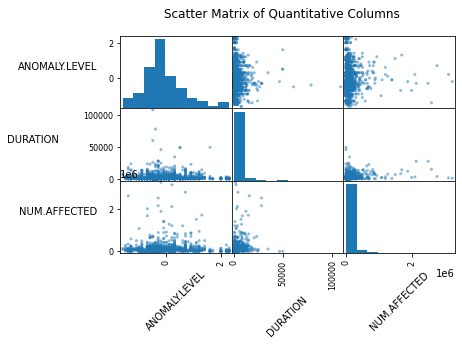

In [9]:
#Plot scatter matrix of all quantitative variables
sm = pd.plotting.scatter_matrix(outages)
plt.suptitle('Scatter Matrix of Quantitative Columns')
#Rotate and space axis labels for legibility
for ax in sm.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.labelpad = 50

Distribution of outage durations grouped by day and night are plotted below:

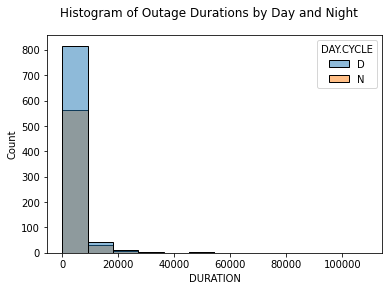

In [10]:
#Assign daytime labels based on regular working hours (8AM-6PM)
outages['DAY.CYCLE'] = outages['START.TIME'].apply(lambda x: None if isinstance(x, float) else 'N' if x < datetime.time(hour=8) or x > datetime.time(hour=18) else 'D')
sns.histplot(x='DURATION', hue='DAY.CYCLE', data=outages, stat='count', bins=12)
plt.suptitle('Histogram of Outage Durations by Day and Night')
plt.show()

### Assessment of Missingness

Columns are examined for missingness. The columns that have the most missing values are details regarding the cause of an outage and the number of customers affected by the outage.

In [11]:
#Calculate proportion of missing data per column
outages.isna().sum() / outages.shape[0]

STATE               0.000000
NERC.REGION         0.000000
ANOMALY.LEVEL       0.005867
CLIMATE.CATEGORY    0.005867
START               0.005867
START.TIME          0.005867
END                 0.037810
END.TIME            0.037810
CAUSE               0.000000
DETAIL              0.307040
DURATION            0.037810
NUM.AFFECTED        0.288787
DAY.CYCLE           0.005867
dtype: float64

A variable that might be not missing at random (NMAR) is the start date/time of outages. Since outage starts are reported by the utility company, there are likely more missing data for outages that occur on federal holidays as a reduced staff decreases a company's ability to stay vigilant on power outage detection. This in turn, makes it more difficult to report the exact start of an outage. Ultimately, we should expect more missing start dates on federal holidays thus making start dates/times of outages not missing at random as they depend on the date and time it happened. The other columns with missing values likely depend on the other variables in the data.

On a side note: Start times and start dates appear missing together in the data as is the case with end dates and times.

One might predict that the missingness of people affected is dependent on the NERC.REGION column, since any privacy policies, unreliable equipment a service company uses could impact delivery of the data.

The following hypotheses are tested using a total variance distriubtion test with $\alpha$ = 0.05:
* $H_0$ = The missingness of NUM.AFFECTED is independent of NERC.REGION
* $H_1$ = The missingness of NUM.AFFECTED is dependent on NERC.REGION

Because the NERC.REGION column is qualitative, missingness must be examined using total variation distance.

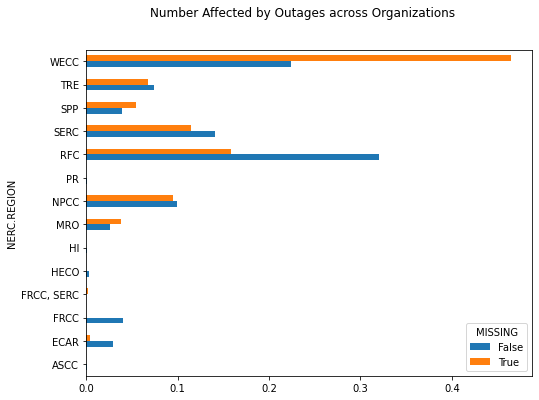

In [12]:
#Select columns and create a table of conditional probabilities of missingness
mcar1 = outages[['NERC.REGION', 'NUM.AFFECTED']]
missing_dist = mcar1.assign(MISSING=mcar1['NUM.AFFECTED'].isna()).pivot_table(index='NERC.REGION',
                                                                              columns='MISSING',
                                                                              values='MISSING',
                                                                              aggfunc='size').fillna(0)
missing_dist = missing_dist / missing_dist.sum()
missing_dist.plot(kind='barh', figsize=(8, 6))
plt.suptitle('Number Affected by Outages across Organizations')
plt.show()

In [13]:
#Define a tvd function for re-use and calculate observed tvd
def tvd(dist):
    return (dist[False] - dist[True]).abs().sum() / dist.shape[0]

obs = tvd(missing_dist)

In [14]:
#Shuffle NERC.REGION labels and calculate TVD of missingness in NUM.AFFECTED column 10000 times
shuffled = mcar1.copy()
tvds = np.array([])
reps = 10000
for _ in range(reps):
    shuffled['NERC.REGION'] = np.random.permutation(mcar1['NERC.REGION'])
    pivot = shuffled.assign(MISSING=shuffled['NUM.AFFECTED'].isna()).pivot_table(index='NERC.REGION',
                                                                                 columns='MISSING',
                                                                                 values='MISSING',
                                                                                 aggfunc='size').fillna(0)
    pivot = pivot / pivot.sum()
    tvds = np.append(tvds, tvd(pivot))

In [15]:
#Calculate p-value
(tvds >= obs).sum() / len(tvds)

0.0

Since the p-value < 0.05, we reject the null hypothesis. It appears that the NUM.AFFECTED column is MAR dependent upon NERC.REGION, though this may be due to some other confounding factor.

On the other hand, climate category is unlikely to affect the missingness of the number of people affected. To confirm this suspicion another permutation test of total variation distance with a significance level of $\alpha$ = 0.05 is used.
* $H_0$ = NUM.AFFECTED is not dependent on the CLIMATE.CATEGORY column
* $H_1$ = NUM.AFFECTED is dependent on the CLIMATE.CATEGORY column

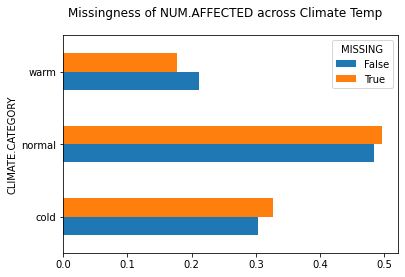

In [16]:
#Reformat relevant columns to a table of conditional probabilities
mcar2 = outages[['CLIMATE.CATEGORY', 'NUM.AFFECTED']]
missing_dist = mcar2.assign(MISSING=mcar2['NUM.AFFECTED'].isna()).pivot_table(index='CLIMATE.CATEGORY', 
                                                                              columns='MISSING', 
                                                                              values='MISSING',
                                                                              aggfunc='size')
missing_dist = missing_dist / missing_dist.sum()
missing_dist.plot(kind='barh')
plt.suptitle('Missingness of NUM.AFFECTED across Climate Temp')
plt.show()

In [17]:
missing_dist[True]

CLIMATE.CATEGORY
cold      0.326531
normal    0.496599
warm      0.176871
Name: True, dtype: float64

In [18]:
#Calculate observed tvd
obs = tvd(missing_dist)
print(obs)
#Simulate test statistic
shuffled = mcar2.copy()
tvds = np.array([])
reps = 10000

for _ in range(reps):
    shuffled['CLIMATE.CATEGORY'] = np.random.permutation(shuffled['CLIMATE.CATEGORY'])
    pivot = shuffled.assign(MISSING=shuffled['NUM.AFFECTED'].isna()).pivot_table(index='CLIMATE.CATEGORY', 
                                                                              columns='MISSING', 
                                                                              values='MISSING',
                                                                              aggfunc='size')
    pivot = pivot / pivot.sum()
    tvds = np.append(tvds, tvd(pivot))

0.023537582314598654


In [19]:
#Calculate p-value
(tvds >= obs).sum() / len(tvds)

0.3522

Since the p-value > 0.05, we fail to reject the null hypothesis. It appears that the number of people affected by a power outage is independent of the climate category the outage occurs in.

### Hypothesis Testing

Do power outages that occur outside of regular working hours (8AM-6PM) last longer?
* $H_0$ = Power outage durations are similarly distributed regardless of when they occur.
* $H_1$ = Power outages that start after-hours last longer.

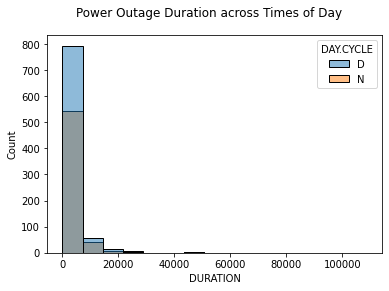

In [20]:
df = outages[['DURATION', 'DAY.CYCLE']]
sns.histplot(x='DURATION', hue='DAY.CYCLE', bins=15, data=df)
plt.suptitle('Power Outage Duration across Times of Day')
plt.show()

Since the two power distributions are similar in shape and spread, a permutation test of the difference in means will suffice. A significance level of $\alpha$ = 0.05 is used.

In [21]:
#Define difference in means function and calculate observed statistic
def diff_means(df):
    means = df.groupby('DAY.CYCLE').mean()['DURATION']
    return means['N'] - means['D']

obs = diff_means(df)
obs

1039.0611812905427

In [22]:
#Shuffle day cycle label and re-compute difference of means
shuffled = df.copy()
stats = np.array([])
reps = 10000
for _ in range(reps):
    shuffled['DAY.CYCLE'] = np.random.permutation(shuffled['DAY.CYCLE'])
    stat = diff_means(shuffled)
    stats = np.append(stats, stat)

In [23]:
#Calculate p-value
(stats >= obs).sum() / len(stats)

0.0005

Since p < 0.05, we reject the null hypothesis. The durations of power outages that occur at night are longer than those that occur during the day.